# Entrenamiento de la CNN 
### Modelización de problemas matemáticos UCM 2020 - Magnagement Solutions
#### Equipo: YOLO - You Only Lose Once

In [1]:
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import random
import sys
import warnings 
import os
warnings.filterwarnings('ignore')
import cv2
import time
import keras
from keras import layers
from keras import models
from keras import optimizers
import copy

import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf


Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
#Fijamos los distintos seeds para minimizar la aleatoriedad (aunque como se comenta en la memoria, no se puede eliminar por completo)

# Seed value
# Apparently you may use different seed values at each stage
seed_value = 27

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
#tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [4]:
'''
Función para cargar las imágenes desde los archivos:
Argumentos: path - directorio en el que se encuentran las fotografías 
Return: X - fotografías convertidas a array
        y - clases a las que pertenecen als fotografías
'''

def load_training_data(path):
    X = np.empty((0,48,48,1))
    Y = np.empty((0,1))
    X_tmp = np.empty((0,48,48,1))
    init_time = time.time()
    t = time.time()
    
    cont = 0
    num_current_folder = 0
    
    #Cargamos las carpetas por separado
    for current_folder in os.listdir(path):
        
        print("Current folder: " + current_folder)
        current_folder_path = os.path.join(path, current_folder)
        
        for image in os.listdir(current_folder_path):
            image_path = os.path.join(current_folder_path, image)

            image_vector = cv2.imread(image_path,0)
            
            # Si queremos aplicar Histogram Equalization descomentamos esta línea
            #image_vector = cv2.equalizeHist(image_vector)
            
            # Si queremos aplicar la técnica CLAHE descomentamos estas líneas
            #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
            #image_vector = clahe.apply(image_vector)
            
            image_vector_np = np.array(image_vector)
            
            X_tmp = np.append(X_tmp, image_vector_np)
            Y = np.append(Y, num_current_folder)
            cont = cont + 1

            #Evitamos hacer appends para mejorar la velocidad de carga
            if cont >= 100:
                X = np.append(X, X_tmp)
                cont = 0
                X_tmp = np.empty((0,48,48,1))

        num_current_folder = num_current_folder + 1

    X = np.append(X, X_tmp)
    X = np.reshape(X, (-1,48,48,1))
           
    print("Time needed: " + str(time.time() - init_time))
        
    return X, Y

Ahora cargamos las fotos tanto de entrenamiento como de test y dividimos el conjunto de entrenamiento en la parte que utilizaremos para entrenar y la que emplearemos para validar el funcionamiento de nuestro modelo.

In [5]:
from sklearn.model_selection import train_test_split

X_train, Y_train = load_training_data(os.path.join('Data','train'))
X_test, Y_test = load_training_data(os.path.join('Data','test'))

#Dividimos el conjunto de entrenamiento en train y validación
X_train, X_val, Y_train, Y_val = train_test_split(X_train, 
                                                  Y_train,
                                                  test_size = 0.1, 
                                                  random_state = 27,
                                                  stratify = Y_train)

#En caso de querer hacer el entrenamiento definitivo, tendríamos que eliminar esta división del conjunto de entrenamiento

#Va separado train y test, y yo de train separo train y validación
#90% test
#10% validación

Current folder: angry
Current folder: disgusted
Current folder: fearful
Current folder: happy
Current folder: neutral
Current folder: sad
Current folder: surprised
Time needed: 27.83521842956543
Current folder: angry
Current folder: disgusted
Current folder: fearful
Current folder: happy
Current folder: neutral
Current folder: sad
Current folder: surprised
Time needed: 3.433363914489746


In [6]:
# Volteamos las imágenes de train, de forma que cada imagen de train pase a estar 2 veces.
# En caso de no querer aplicar este preprocesado comentamos el código

X_train_2 = np.empty((0,48,48,1));
X_aux = np.empty((0,48,48,1));
Y_train_2 = np.empty((0,1))
cont = 0
gr = 0

for img, sol in zip(X_train, Y_train):
    img.reshape(48,48)
    flipHorizontal = copy.deepcopy(img)
    flipHorizontal = cv2.flip(flipHorizontal, 1)
    flipHorizontal_np = np.array(flipHorizontal)
    
    X_aux = np.append(X_aux, img)
    X_aux = np.append(X_aux, flipHorizontal_np)
    Y_train_2 = np.append(Y_train_2, sol)
    Y_train_2 = np.append(Y_train_2, sol)
    cont = cont + 2
    
    if cont > 100:
        X_train_2 = np.append(X_train_2, X_aux)
        X_aux = np.empty((0,48,48,1));
        cont = 0
        gr = gr + 1
        
X_train_2 = np.append(X_train_2, X_aux)
        
X_train_2 = np.reshape(X_train_2, (-1,48,48,1))

X_train = X_train_2
Y_train = Y_train_2

In [7]:
print("Tamaño del conjunto de entrenamiento: " + str(X_train.shape))
print("Tamaño del conjunto de validación: " + str(X_val.shape))
print("Tamaño del conjunto de test: " + str(X_test.shape))

Tamaño del conjunto de entrenamiento: (51618, 48, 48, 1)
Tamaño del conjunto de validación: (2868, 48, 48, 1)
Tamaño del conjunto de test: (7178, 48, 48, 1)


Transformamos el vector objetivo a codificacion one-hot, que es la que espera nuestra red neuronal

In [8]:
def one_hot_encoding(Y, n = 7):
    Y_one_hot = np.empty((0, n))
    
    for i in range(0, len(Y)):
        np_oh = np.zeros(n)
        np_oh[int(Y[i])] = 1
        Y_one_hot = np.append(Y_one_hot, np_oh)
        
        
    Y_one_hot = np.reshape(Y_one_hot, (-1, 7))
    return Y_one_hot
        

In [9]:
import copy

Y_test = one_hot_encoding(Y_test)
Y_val = one_hot_encoding(Y_val)
Y_train = one_hot_encoding(Y_train)

print("Tamaño del conjunto de entrenamiento: " + str(Y_train.shape))
print("Tamaño del conjunto de validación: " + str(Y_val.shape))
print("Tamaño del conjunto de test: " + str(Y_test.shape))

Tamaño del conjunto de entrenamiento: (51618, 7)
Tamaño del conjunto de validación: (2868, 7)
Tamaño del conjunto de test: (7178, 7)


## Entrenamiento de la red
En las siguientes celdas, definimos la red, la entrenamos y la guardamos

In [10]:
# Esta es la arquitectura final de nuestra red (la F). En caso de querer cualquier otra,
#   simplemente cambiar por las capas adecuadas
from tensorflow.keras import regularizers

modelN = models.Sequential()
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                        input_shape=(48, 48, 1)))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.AveragePooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.AveragePooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.AveragePooling2D(pool_size=(2, 2)))

modelN.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(64, activation='relu'))

modelN.add(layers.Dense(7, kernel_regularizer=regularizers.l2(0.0001)))
modelN.add(layers.Activation('linear'))

In [11]:
# Si queremos información sobre la red descomentamos esta línea
#modelN.summary()

In [12]:
#Entrenamos nuestra red
# optimizer:
modelN.compile(loss='squared_hinge', optimizer='adam', metrics=['accuracy'])
print ('Training....')


#fit
nb_epoch = 12
batch_size = 128

ini_entrenamiento = time.time()

modelF = modelN.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size,
          validation_data=(X_test, Y_test), shuffle=True, verbose=1)

print("Tiempo de entrenamiento: " + str(time.time() - ini_entrenamiento))

Training....
Train on 51618 samples, validate on 7178 samples
Epoch 1/12
51618/51618 [==============================] - 19s 373us/step - loss: 0.4406 - accuracy: 0.3580 - val_loss: 0.3867 - val_accuracy: 0.4588
Epoch 2/12
51618/51618 [==============================] - 17s 327us/step - loss: 0.3621 - accuracy: 0.5013 - val_loss: 0.3413 - val_accuracy: 0.5334
Epoch 3/12
51618/51618 [==============================] - 17s 323us/step - loss: 0.3277 - accuracy: 0.5617 - val_loss: 0.3279 - val_accuracy: 0.5585
Epoch 4/12
51618/51618 [==============================] - 16s 320us/step - loss: 0.3030 - accuracy: 0.6005 - val_loss: 0.3305 - val_accuracy: 0.5659
Epoch 5/12
51618/51618 [==============================] - 17s 322us/step - loss: 0.2845 - accuracy: 0.6300 - val_loss: 0.3046 - val_accuracy: 0.5981
Epoch 6/12
51618/51618 [==============================] - 16s 319us/step - loss: 0.2661 - accuracy: 0.6597 - val_loss: 0.3026 - val_accuracy: 0.6062
Epoch 7/12
51618/51618 [====================

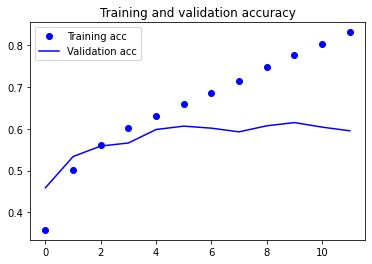

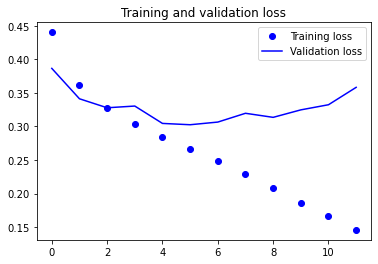

In [13]:
#Guardamos nuestro modelo y mostramos las gráficas con el entrenamiento
modelN.save('modelo_guardado')

acc = modelF.history['accuracy']
val_acc = modelF.history['val_accuracy']
loss = modelF.history['loss']
val_loss = modelF.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Observar los resultados del modelo 

In [14]:
#Si queremos cargar directamente un modelo ya entrenado, lo cargamos con esta función
#modelN = keras.models.load_model('modelo_guardado')

Y ahora vemos los resultados sobre los diferentes conjuntos

In [15]:
# Conjunto de test
score = modelN.evaluate(X_test, Y_test, verbose=1)
print ("model %s: %.2f%%" % (modelN.metrics_names[1], score[1]*100))

7178/7178 [==============================] - 2s 244us/step
model accuracy: 59.50%


In [16]:
# Conjunto de validación
score = modelN.evaluate(X_val, Y_val, verbose=1)
print ("model %s: %.2f%%" % (modelN.metrics_names[1], score[1]*100))

2868/2868 [==============================] - 1s 295us/step
model accuracy: 59.52%


In [17]:
# Conjunto de train
score = modelN.evaluate(X_train, Y_train, verbose=1)
print ("model %s: %.2f%%" % (modelN.metrics_names[1], score[1]*100))

51618/51618 [==============================] - 11s 208us/step
model accuracy: 86.08%
